# Overview

In this notebook we explore the gaussian process.

As the name suggests the gaussian process is a stochastic process characterized by the gaussian distribution. For more information consider the materials provided in the [Stocastics notebook](Stochastics.ipynb) and the notebook for the [Normal distribution](../Probability/Normal%20Distribution/Normal%20Distribution.ipynb).

The following guides helped create this notebook:
- https://distill.pub/2019/visual-exploration-gaussian-processes/
- https://brendanhasz.github.io/2018/10/10/hmm-vs-gp.html

In [ ]:
import numpy
import pandas
from matplotlib import pyplot, cm
import scipy

from scipy.stats import multivariate_normal


## Covariance is important
its a contraint that keeps like terms together
https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

Matrix being positive definite This is the multivariate analog of the univariate requirement for the variance σ2 to be positive. 
https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

## Kernels For A Gaussian Process

**Note:** Kernels appear in a number of mathematical fields and is often presented in an applied context with a more specific definition. They are used in image processing, interpolation, machine learning, and more. For a primer consider the following texts 
- https://www.cs.princeton.edu/~bee/courses/scribe/lec_10_09_2013.pdf
- [The kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/)

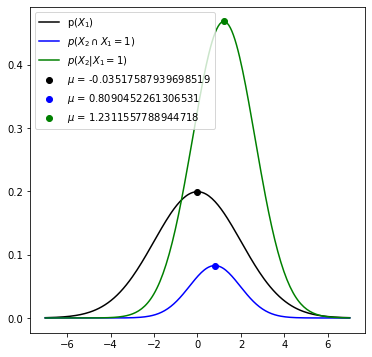

In [2]:
import numpy
import scipy
from scipy.stats import multivariate_normal
from matplotlib import pyplot

# Generate a random normal variable which we will use to calculate probabilities
mu = [0, 0]
sigma = numpy.array([[1, 0.8],[0.8,2]])
rv = multivariate_normal(mu, sigma)

# Generate a number line
x = numpy.linspace(-7, 7, 200)

# Generate probabilities for the first random variable
normal_uv_rv = scipy.stats.norm(loc=0, scale=2)
p1 = normal_uv_rv.pdf(x)
x_1 = 1
p_x_1 = normal_uv_rv.pdf(x_1)

# Generate joint probabilities with a fixed X_1
x2 = x.copy()
grid_coord = numpy.column_stack((numpy.full(x2.shape, 1), x2))
p_x2_and_x1 = rv.pdf(grid_coord)

# Generate conditional probabilities given a fixed X_1
p_x2_given_x1 = p_x2_and_x1 / p1

# Calculate the means of the distributions
i = numpy.argmax(p1)
p1_mean_x = x[i]
p1_mean = p1[i]
i = numpy.argmax(p_x2_and_x1)
p_x2_and_x1_mean_x = x[i]
p_x2_and_x1_mean = p_x2_and_x1[i]
i = numpy.argmax(p_x2_given_x1)
p_x2_given_x1_mean_x = x[i]
p_x2_given_x1_mean = p_x2_given_x1[i]

# Plot
fig, ax = pyplot.subplots()
fig.set_figwidth(6)
fig.set_figheight(6)
ax.plot(x, p1, c='black')
ax.plot(x, p_x2_and_x1, c='blue')
ax.plot(x, p_x2_given_x1, c='green')
ax.scatter(p1_mean_x, p1_mean, c='black')
ax.scatter(p_x2_and_x1_mean_x, p_x2_and_x1_mean, c='blue')
ax.scatter(p_x2_given_x1_mean_x, p_x2_given_x1_mean, c='green')
ax.legend([
    "p($X_1)$", 
    "$p(X_2 \cap X_1=1)$", 
    "$p(X_2|X_1=1)$",
    "$\mu$ = {0}".format(p1_mean_x),
    "$\mu$ = {0}".format(p_x2_and_x1_mean_x),
    "$\mu$ = {0}".format(p_x2_given_x1_mean_x)
]);

### Gaussian (Squared Exponential)

$$ K(x, y) : \alpha^2 exp \left( {-\frac{(x - y)^2}{2\rho^2}} \right) + \sigma^2 \delta_{x, y} $$

The parameters are defined as follows:

- $\alpha$ - a hyper parameter which controls how likely the kernel returns a value near zero
- $\rho$
- $\sigma$
- $\delta$ - takes a value from 0 to 1 depending on whether or not 


In the diagram above, we can see the the effects on the distributions as we fix a variable. We see that the distributions move to the right by looking at the means (visually indicated by the peaks) and we see that the distributions narrow by looking at the variance (visually indicated by the widths). The green distribution shows us the unconditional probability of $X_1$. This distribution will also describe the unconditional probability of $X_2$. We see this distribution of $X_2$ changes as we fix a value of $X_1=1$. 

Looking at the black distribution, we see that the probability of obtaining any value of $X_2$ and obtaining a value $X_1=1$ is generally smaller than obtaining the same value of $X_2$ independently. This intuitively makes sense as there is a smaller chance that two things happen at the same time. Intuitively this makes sense: we are multiplying a small number (smaller than one) by another small number... so we will get an even smaller number. We also see that the mean of the distribution has moved to the right. This indicates that the value $X_2$ is likely to take is somewhere around 1 rather than 0. Additionally we see that the variance of the distribution shrinks which indicates that the range of values that the variable is likely to take on is also shrinking (definition of variance).

Finally, with the green distribution, we see that the $X_2$ is most likely to take on a value of 1.23 given that $X_1=1$.

We can look at the different shapes that the distribution will take on as the parameters change.

In [ ]:
import numpy
import itertools
from scipy.stats import multivariate_normal
from matplotlib import pyplot

def gaussian_kernel(diff, a, p, s, d):
    
    return a**2 * numpy.exp(-(diff)**2/2*p**2) + s**2 * d

def plot_variable(ax, diff, a, p, s, d):
    
    # Calculate the kernel values
    g = gaussian_kernel(diff, a, p, s, d)

# Generate a number line
diff = numpy.linspace(-5, 5, 200)

# Generate potting objects
fig, ax = pyplot.subplots(2,2)
ax = [ax[0][0],ax[0][1], ax[1][0], ax[1][1]]
fig.set_figwidth(12)
fig.set_figheight(12)
#ax.set_xlabel('x - y')
#ax.set_ylabel('K(x, y)')

params = ['a', 'p', 's', 'd']
possible_values = {
    'a': [-1, -.5, 0.1, .5, 1, 2, 5],
    's': [-1, -.5, 0.1, .5, 1, 2, 5],
    'p': [-1, -.5, 0.1, .5, 1, 2, 5],
    'd': [0, 1]
}
defaults = {
    'a': 1,
    's': 1,
    'p': 1/2,
    'd': 1
}
    
for i in range(0, len(params)):

    varied_param = params[i]
    
    # Set the defaults
    for j in range(0, len(params)):
        param_name = params[j]
        param_default = defaults[param_name]
        exec("{0} = {1}".format(param_name, param_default))
            
    legend_labels = []
    for value in possible_values[varied_param]:

        # Set the value of the variable that will be varried
        exec("{0} = {1}".format(varied_param, value))
                
        # Calculate the kernel values
        g = gaussian_kernel(diff, a, p, s, d)

        # Get the axis
        ax[i].plot(diff, g)
        
        legend_labels.append("a={0}, p={1}, s={2}, d={3}".format(a, p, s, d))
        
        ax[i].set_title(varied_param)
        
    ax[i].legend(legend_labels);

In [ ]:
        
        # plot
        if line_count < 10:
            ax.plot(diff, g)
        elif line_count < 20:
            ax.plot(diff, g, '--')
        elif line_count < 30:
            ax.plot(diff, g, '.')
        else:
            ax.plot(diff, g)

    legend_labels.append("a={0}, p={1}, s={2}, d={3}".format(a, p, s, d))
    
    line_count += 1
    
ax.legend(legend_labels);

In [ ]:
def gaussian_kernel(diff, a, p, s, d):
    
    return a**2 * numpy.exp(-(diff)**2/2*p**2) + s**2 * d


import numpy
import itertools
from scipy.stats import multivariate_normal
from matplotlib import pyplot

# Generate a number line
diff = numpy.linspace(-5, 5, 200)

# Generate potting objects
fig, ax = pyplot.subplots()
fig.set_figwidth(12)
fig.set_figheight(12)
ax.set_xlabel('x - y')
ax.set_ylabel('K(x, y)')

# Set the hyperparameters
possible_parameter_values = [0.1, 0.5, 1, 1.5, 2, 3]
permutations = itertools.combinations_with_replacement(possible_parameter_values, r=4)

legend_labels = []
line_count = 0
for permutation in permutations:
    
    a, p, s, d = permutation
    
    # Calculate the kernel values
    g = gaussian_kernel(diff, a, p, s, d)
    
    # Ignore those which do not behave like a probability distribution
    if g[numpy.argmax(g)] > 1:
        continue

    # plot
    if line_count < 10:
        ax.plot(diff, g)
    elif line_count < 20:
        ax.plot(diff, g, '--')
    elif line_count < 30:
        ax.plot(diff, g, '.')

    legend_labels.append("a={0}, p={1}, s={2}, d={3}".format(a, p, s, d))
    
    line_count += 1
    
ax.legend(legend_labels);

In [ ]:
line_count

# Kernels and Covariance

The covariance is such that the value returned is large if the values of the random variables are close to each other and small if they are not. It is defined mathematically as:

$$ Cov(X, Y) = E \left[(X - \mu_X)(Y-\mu_y) \right] $$
$$ = E[XY] - \mu_X \mu_Y $$

It is often derived as

$$ = \frac{\sum (X - \mu_X)(Y-\mu_y)}{n} $$

Knowing these are gaussian processes we assert $\mu=0$ which implies

$$ = \frac{\sum XY}{n} $$

For a single point, where $n=1$ we can further reduce the equation to

$$ = XY $$

We can think of the covariance matrix as a function which accepts a set of independent variables and returns their covariance:

$$ \Sigma = f(x, y) $$


We can see that this function satisfies the properties of a kernel function and thus we can say the covariance function is a kernel function

$$ \Sigma = K(x, y) $$

## Choosing an alternate kernel

We could select an alternate function which returns a different measurement based on the relationship between the vairable pair.

For example, we could choose a function which describes the distance between the two variables without consideration of the respective means. We could additionally choose a function that behaves like a probability distribution and returns a quasi-probability indicating the likelihood of obtaining a value of one variable given another variable.

The gaussian kernel does just this.

Graph showing impact of different kernels

<center><img src='images/kernels_affecting_gaussian_process.png'  width='800px' height='800px' ></center>

https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

**Note:** Like the model of Brownian motion, Gaussian processes are stochastic processes. In fact, the Brownian motion process can be reformulated as a Gaussian process.

https://peterroelants.github.io/posts/gaussian-process-tutorial/

# Gaussian Process

A guassian process is a stochastic process which is characterized by a gaussian distribution.

$$ X_t \sim \mathcal{N}$$

The gaussian distribution is parameterized by two parameters and in our case we will look at the multivariate generalization: 

$$\mathcal{N} := \phi(\mu, \Sigma)$$.

In most cases, we want to use the gaussian process of a way to model our data (We will see more on this in the following section about gaussian process regression). This means that we are not interested in memoryless noise and instead are interested in data that exhibits some sort of trend. We will restate our process as one which is dependent on another random process:

$$ Z_t : X_t \xrightarrow{\mathcal{N}}Y_t $$

To accomplish this, we can transform the distribution function slightly by replacing constants with functions that consider the process index.

$$ \mu_t := f_\mu(X_t) $$
$$ \Sigma_t := f_\Sigma(Y_t, X_t)$$

$$ Z_t \sim \phi(\mu_t, \Sigma_t)$$

We can then configure the functions so that they maintain the "memory" for out process and consider prior points recursively. In the simple case below we only consider the previous data points. 

We do this using the definition of conditional probabilities and Bayes Theorem. We can construct a mathematical framework to express the probability of the next value given the past values.

$$  P(X_t|X_{t-1}) = \frac{P(X_{t_n}, X_{t-1})}{P(X_{t-1})} $$

Due to the special properties of the joint normal distribution we can algebraically derrive the conditional probability distribution formula:

$$ Z_t \sim \phi(\mu_{Y_t|X_{t-1}}, \Sigma_{Y_t|X_{t-1}})$$

We can then calculate the conditional time dependent expected value $\mu_{X_t|X_{t-1}}$ and variance $\Sigma_{X_t|X_{t-1}}$ using block inversion and the schurs complement. 

Note: This is very hard matrix algebra which I cannot understand/prove yet. I am still reviewing books etc to learn how this is done. For now, we will jump right to the answer:

$$ \mu_{Y_t|X_{t-1}} = \mu_{Y_t}+\Sigma_{2,1}\Sigma_{1,1}^{-1}(Y_{t-1} - \mu_{X_{t-1}}) $$

$$ \Sigma_{Y_t|X_{t-1}} = \Sigma_{1,1}-\Sigma_{1,2}\Sigma_{1,1}^1\Sigma_{1,2} $$

While this is the general answer, we can further simplify these equations given our constraints on the distribution. Specifically, we can impose that the mean is zero:

$$ \mu_{Y_t|X_{t-1}} = \mu_{Y_t}+\Sigma_{2,1}\Sigma_{1,1}^{-1}(Y_{t-1} - \mu_{X_{t-1}}) $$

$$  = 0 +\Sigma_{2,1}\Sigma_{1,1}^{-1}(Y_{t-1} - 0) $$

$$ = \Sigma_{2,1}\Sigma_{1,1}^{-1}Y_{t-1} $$



$$ \mu_{X_t|X_{t-1}} := \begin{bmatrix}  
\mu_{X_t|X_{t-1}} \\
\mu_{X_{t-1}|X_t}
\end{bmatrix}
$$

$$ \Sigma_t := \begin{bmatrix}  
\sigma^2_{X_{t-1}|X_t} & \sigma_{X_{t-1}|X_t} \\
\sigma_{X_t,X_{t-1}} & \sigma^2_{X_{t}|X_{t-1}}
\end{bmatrix}
$$

Expanding our process notation we then have the following constraint which enforces our recursion and providesthe mechonism for our process to have memory.

$$\begin{bmatrix}  
Y_{t-1} \\
Y_t
\end{bmatrix} \sim \mathcal{N} \left( 
\begin{bmatrix}  
\mu_{X_{t-1}} \\
\mu_{X_t}
\end{bmatrix}, 
\begin{bmatrix}  
\sigma^2_{X_{t-1}} & \sigma_{X_{t-1},X_t} \\
\sigma_{X_t,X_{t-1}} & \sigma^2_{X_t}
\end{bmatrix}
\right)
$$


If we run a monte carlo simulation we can realize a random path for our process. Each iteration we would need to calculate the values for the distribution parameters.

Through these functions we have a machanism for adjusting the process as it evolves. We can for example construct a recursive relationship such that the the process is dependent on prior values.

$$ X_t = X_{t - 1} + ??$$

https://peterroelants.github.io/posts/gaussian-process-tutorial/

Consider the Brownian Motion with drift parameter $\mu$ and noise parameter $\sigma$.

$$ \mathcal{W}_t = \mu + \sigma \phi_t $$

[link](https://stats.libretexts.org/Bookshelves/Probability_Theory/Probability_Mathematical_Statistics_and_Stochastic_Processes_(Siegrist)/18%3A_Brownian_Motion/18.04%3A_Geometric_Brownian_Motion#:~:text=The%20stochastic%20process%20X%3D%7BX,%CE%BC%20and%20volatility%20parameter%20%CF%83.&text=Note%20that%20the%20deterministic%20part,decay%2C%20with%20rate%20parameter%20%CE%BC.)

Using this information we calibrate a recursive stochastic process. For example we may start with a random walk


Below we see an example of a random walk which

$$ X_t = \mathcal{W}_t f_t $$

https://www.cs.toronto.edu/~rsalakhu/STAD68/notes/Lecture7_2014.pdf

The recursion of the gaussian process is defined by bayes theorem being slightly adapted to fit the context of a time-dependent process.

$$ P(f|\mathcal{D}) = \frac{P(\mathcal{D}|A)P(A)}{P(\mathcal{D})} $$

https://www.cs.toronto.edu/~rsalakhu/STAD68/notes/Lecture7_2014.pdf

We can create a stochastic regression model which uses the gaussian process and a recursive contraint to calibrate the model so that it fits the data. Iltimately the distribution $\phi$ is derived recursively




We can constructe the recursive relationship so that the next point generated by the process is expressed using the previous point:

$$ Y := \begin{bmatrix} 
y_1 \\ 
y_2 
\end{bmatrix} \sim \mathcal{N}(\mu,  \Sigma) $$

$$ \mu :=  \begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix}, \ where \ \mu_i \Rightarrow X_i $$

$$ \Sigma := \begin{bmatrix} 
\sigma^2_1 & \sigma_{1,2} \\
\sigma_{2,1} & \sigma^2_2
\end{bmatrix}, \ where \ \sigma_i \Rightarrow X_i $$

https://peterroelants.github.io/posts/gaussian-process-tutorial/

We can get the conditional distribution to express the probability of $y_2$ given $x_1$, $y_1$, and $x_2$ have occurred

$$ p(y_2 | y1, x1, x2) \sim \mathcal{N}(\mu_{2|1}, \Sigma_{2|1}) $$

** Note sure why: "The gaussian proccess assumes that values within a search space will be most similar bewteen neighboring points. We will see this assumption is enforced as part of the mathematical framework."

-> see covariance commets about kernels

Assume we have a variable or function which depends on a set of parameters:

$$ y = f(X) $$

Assume variable or function is being modeled is a gaussian process:

$$ \hat y \sim \mathcal{N}(\mu, \Sigma) $$

# Gaussian Process Regression
Gussian process regression is a technique which calibrates a [gussian process](../Stochastics/Stochastics.ipynb#Gaussian-Process) so that it models a set of observations. The intent is that once calibrated appropriately, the model can be used to make predictions. This technique goes by a few names including:krigging and Wiener–Kolmogorov prediction.

## History and Origin
The theoretical basis for the method was developed by the French mathematician Georges Matheron in 1960
His work was based on the Master's thesis of Danie G. Krige who sought to estimate the most likely distribution of gold based on samples from a few boreholes. The term kriging was coined some time after in honor of Krige.
https://en.wikipedia.org/wiki/Kriging

## Technique
The technique starts by asserting that a function expresses a gaussian process:

$$ f(t) \approx \mathcal{G}_t$$

In other words we assert that

$$ \mathcal{G}_t = \mathcal{N}(\mu_t, \Sigma_t)$$

We can split our index into two segments based on what has occured and what has not occurred. We will refer to these as segment one and segment two respectively:

$$\begin{pmatrix}\mathcal{G}_1 \\ \mathcal{G}_2\end{pmatrix}
=
\mathcal{N}
\begin{pmatrix}
    \begin{bmatrix}
    \mu_1 \\
    \mu_2
    \end{bmatrix},
    \begin{bmatrix}
    \Sigma_1 & \Sigma_{1,2} \\
    \Sigma_{2,1} & \Sigma_{2,2}
    \end{bmatrix}
\end{pmatrix}
$$

We then apply the bayesian framework to assert that the distribution for a given point $t$ is based on all previous observations. In other words, the next value is conditional on the previous. With this assertion we must calculate conditional statistics

$$ \mu_{\mathcal{G}_2|\mathcal{G}_1} =  \mu_1 + \Sigma_{1,2}\Sigma_2^{-1}(x_2 - \mu_2)$$

$$ \Sigma_{\mathcal{G}_2|\mathcal{G}_1} = \Sigma_{1,1} - \Sigma_{1,2}\Sigma_{2,2}^{-1}\Sigma_{2,1}$$

so that we can derive a conditional probability

$$ \mathcal{G}_2|\mathcal{G}_1 = \mathcal{N}(\mu_{\mathcal{G}_2|\mathcal{G}_1}, \Sigma_{\mathcal{G}_2|\mathcal{G}_1}) $$

Additionally we may choose to replace the calculation of the covariance $\Sigma$ with an alternate kernel function. The pros and cons of these alternate kernels is discussed in its own section.

## Limitations

- Slow inference. Computing the covariance matrix’s inverse has a O(N3) time complexity, rendering exact inference too slow for more than a few thousand data points.
- Choosing a covariance kernel. There’s some arbitrariness when choosing a kernel. However, the kernel’s hyperparameters can be inferred by maximizing the marginal likelihood, and the whole process can be automated.
- Gaussian processes are in some sense idealizations. For the understanding of extreme phenomena exhibited by real physical systems, non-Gaussian processes might turn out more suitable. In this context, GPs serve as starting points to be perturbed.

https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

# References
- https://www.ritchievink.com/blog/2019/02/01/an-intuitive-introduction-to-gaussian-processes/
- http://www.gaussianprocess.org/
- https://brendanhasz.github.io/2018/10/10/hmm-vs-gp.html
- https://distill.pub/2019/visual-exploration-gaussian-processes/
- https://online.stat.psu.edu/stat505/book/export/html/638
- https://peterroelants.github.io/posts/gaussian-process-tutorial/
- https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html